### This notebook is used to plot the parameter sweeps at the end of notebook 3. This notebook will only work after you run those cells in notebook 3 as the data files are too large to attach to the github repository.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import xarray as xr
import cmasher as cmr
from scipy import stats

In [2]:
plt.rcParams.update({'font.size':10, 'font.sans-serif':'Arial'})

In [3]:
cnt0 = xr.load_dataarray('Data/RSoXS/CNT_pol0_WAXS.nc')
cnt0_saxs = xr.load_dataarray('Data/RSoXS/CNT_pol0_SAXS.nc')

horz_exp = cnt0.sel(chi=slice(-20,20)).mean('chi')
vert_exp = cnt0.sel(chi=slice(-110,-70)).mean('chi')
A_exp = (horz_exp - vert_exp) / (horz_exp + vert_exp)

### upper left plot
exp_ax0 = horz_exp.sel(energy=285)
exp_ax0_1 = vert_exp.sel(energy=285)

norm_val = exp_ax0.sel(q=slice(0.06,0.07)).mean('q')
### upper right plot
isi_exp = cnt0.sel(q=slice(0.06,0.07)).mean(['q','chi'])
exp_ax1 = (isi_exp/isi_exp.sel(energy=285))

### lower left plot
exp_ax2 = A_exp.sel(energy=285).sel(q=slice(0.0175, 0.09))
exp_ax2_1 = A_exp.sel(energy=292).sel(q=slice(0.0175, 0.09))

### lower right plot
exp_ax3= A_exp.sel(q=slice(0.06, 0.07)).mean('q')

In [4]:
def save_plot_multiple(simulation_chi, radius_value, radius_sigma_value, hollow_value, count,color):
    if count == 0:
        (exp_ax0).sel(q=slice(1.5e-2,.15)).plot(yscale='log',xscale='log', ax=ax[0],color='r',label='Exp')
        exp_ax0_1.plot(ax=ax[0], color='r', linestyle='--')
        exp_ax1.plot(ax=ax[1], color='r')
        exp_ax2.plot(ax=ax[2], color='r')
        exp_ax2_1.plot(ax=ax[2], color='r', linestyle='--')
        exp_ax3.plot(ax=ax[3], color='r')

    
    horz = simulation_chi.sel(chi=slice(-20,20)).mean('chi')
    vert = simulation_chi.sel(chi=slice(-110,-70)).mean('chi')
    A = (horz - vert) / (horz + vert)
    isi_sim = simulation_chi.sel(q=slice(0.06,0.07)).mean(['q','chi'])
    
    ### simulation plotting
    (horz.sel(energy=285)/horz.sel(energy=285, q=slice(0.06,0.07)).mean('q')*norm_val).plot(ax=ax[0], label=hollow_fraction,color=color)
    (vert.sel(energy=285)/horz.sel(energy=285, q=slice(0.06,0.07)).mean('q')*norm_val).plot(ax=ax[0], label=hollow_fraction,color=color)    
    (isi_sim/isi_sim.sel(energy=285)).plot(ax=ax[1],color=color)
    A.sel(energy=285,q=slice(1e-2,.1)).plot(ax=ax[2],color=color)
    A.sel(energy=292, q=slice(1e-2, 0.1)).plot(ax=ax[2],color=color)
    A.sel(q=slice(0.06, 0.07)).mean('q').plot(ax=ax[3],color=color)

In [5]:
radii_mu = [2.02, 2.12, 2.22, 2.32, 2.42]
radii_sigma = [0.225, 0.275, 0.325, 0.375, 0.425]
hollow_fractions = [0.125, 0.225, 0.325, 0.425, 0.525]

param_combos = []
for radius_mu in radii_mu:
    for radius_sigma in radii_sigma:
        for hollow_fraction in hollow_fractions:
            param_combos.append([radius_mu, radius_sigma, hollow_fraction])

r_vary = [i for i, combo in enumerate(param_combos) if (combo[1]==0.225) & (combo[2]==0.325)]
sigma_vary = [i for i, combo in enumerate(param_combos) if (combo[0]==2.22) & (combo[2]==0.325)]
h_vary = [i for i, combo in enumerate(param_combos) if (combo[0]==2.22) & (combo[1]==0.275)]

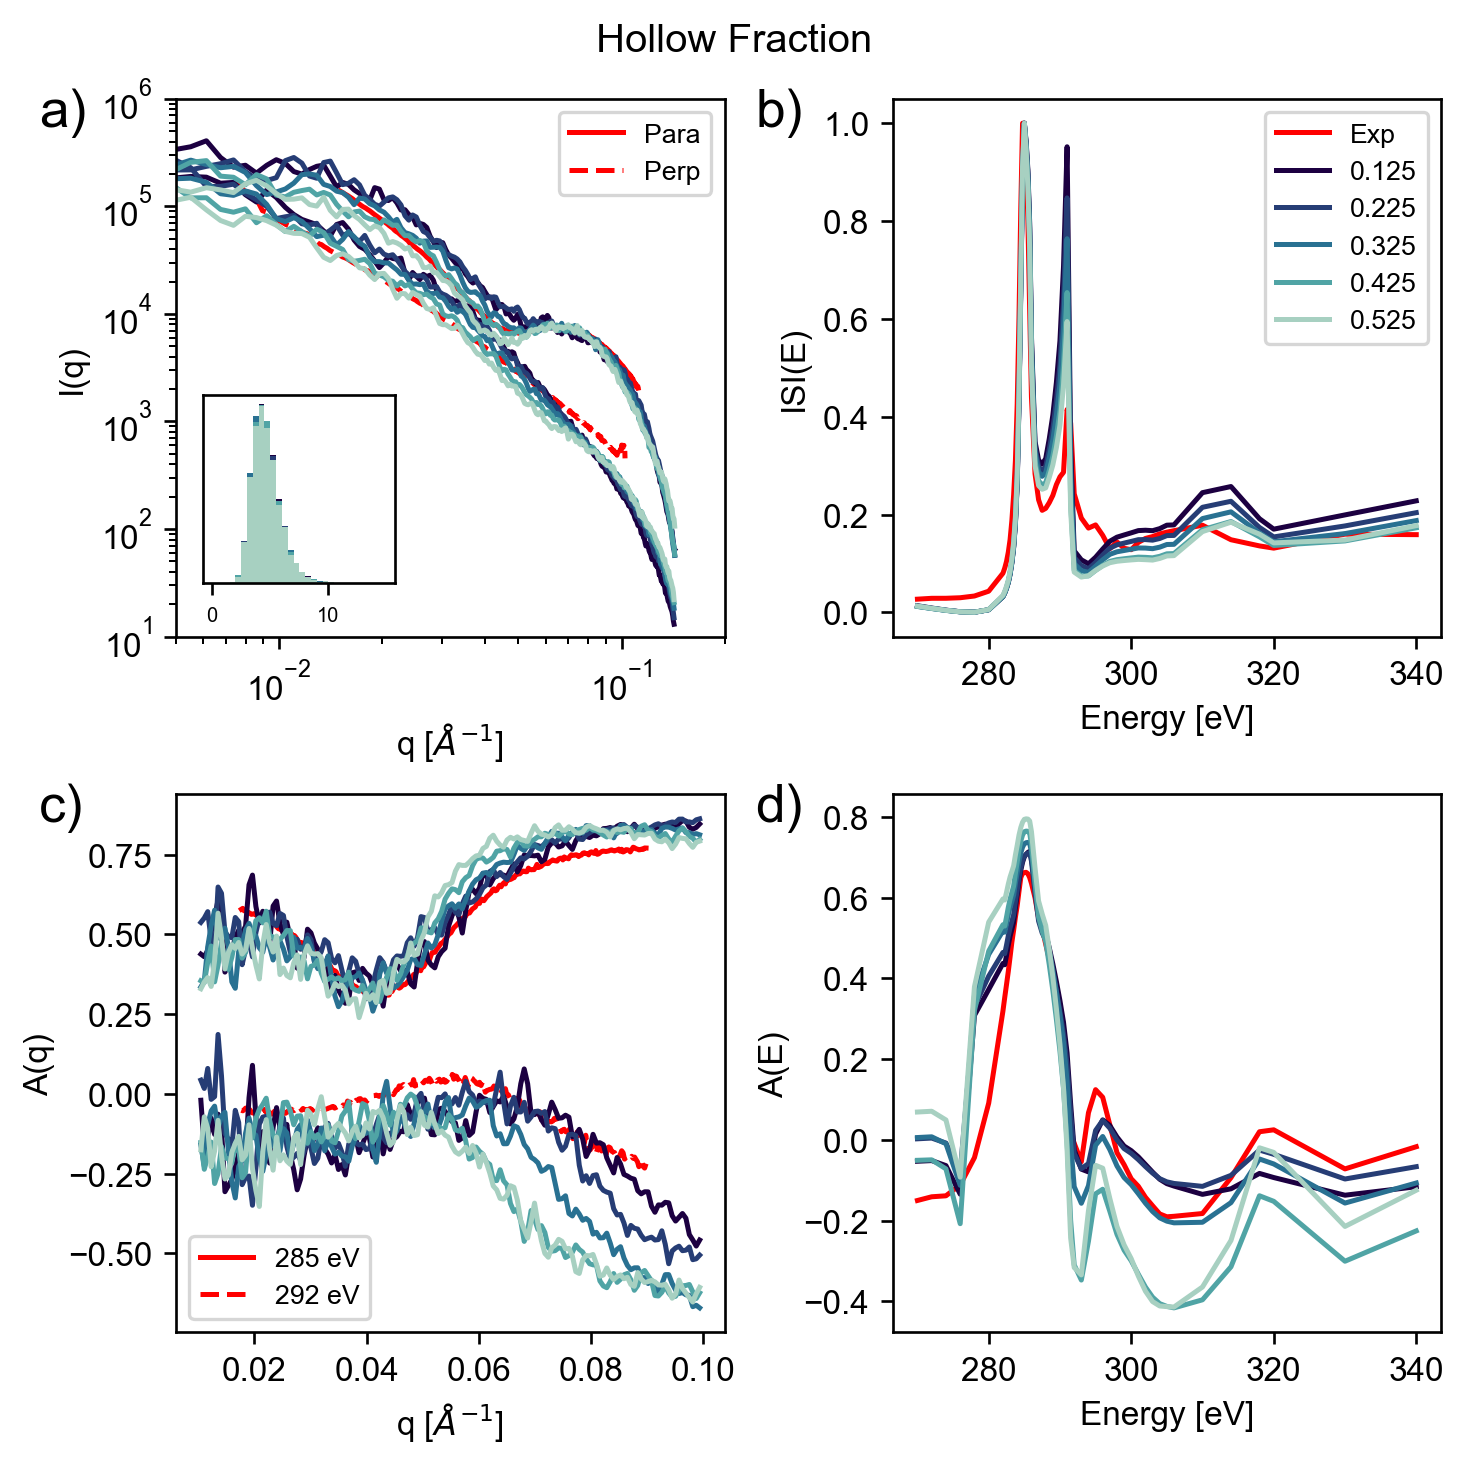

In [6]:
count = 0
fig, ax = plt.subplots(2,2,figsize=(6,6),dpi=240,constrained_layout=True)
ax = ax.flatten()
## inset
ax_ins = ax[0].inset_axes([0.05, 0.1, 0.35, 0.35])
colors = cmr.ocean(np.linspace(0,1,6))
for i in h_vary:
    da1 = xr.load_dataarray(f'Data/parameter_sweep/paramsweep_{i}.nc')
    _ = save_plot_multiple(da1, da1.radius_mu, da1.radius_sigma, da1.hollow_fraction, count, colors[count])
    _ = ax_ins.hist(da1.attrs['cnt_radii'], bins=30, color=colors[count],range=(0,15))
    count +=1



ax[0].set_ylim(1e1,1e6)
ax[0].set_xlim(5e-3, 0.2)
{axes.set_title('') for axes in ax}
ax[0].set_xlabel(r'q [$\AA^{-1}$]')
ax[2].set_xlabel(r'q [$\AA^{-1}$]')

ax[0].legend(['Para', 'Perp'], fontsize=8)
ax[2].legend(['285 eV', '292 eV'], fontsize=8, loc='lower left')

ax[1].set_xlabel('Energy [eV]')
ax[3].set_xlabel('Energy [eV]')
ax[0].set_ylabel('I(q)')
ax[1].set_ylabel('ISI(E)')
ax[2].set_ylabel('A(q)')
ax[3].set_ylabel('A(E)')

ax[0].text(-0.25, 0.95, 'a)', transform=ax[0].transAxes, fontsize=16)
ax[1].text(-0.25, 0.95, 'b)', transform=ax[1].transAxes, fontsize=16)
ax[2].text(-0.25, 0.95, 'c)', transform=ax[2].transAxes, fontsize=16)
ax[3].text(-0.25, 0.95, 'd)', transform=ax[3].transAxes, fontsize=16)

ax[1].legend(['Exp', *[str(h) for h in hollow_fractions]],fontsize=8)
plt.suptitle('Hollow Fraction')
ax_ins.tick_params(axis='both', left=False, labelleft=False,labelsize=6)
plt.savefig('Figures/hollow_fraction_sweep.pdf', format='pdf', bbox_inches='tight')
plt.show()

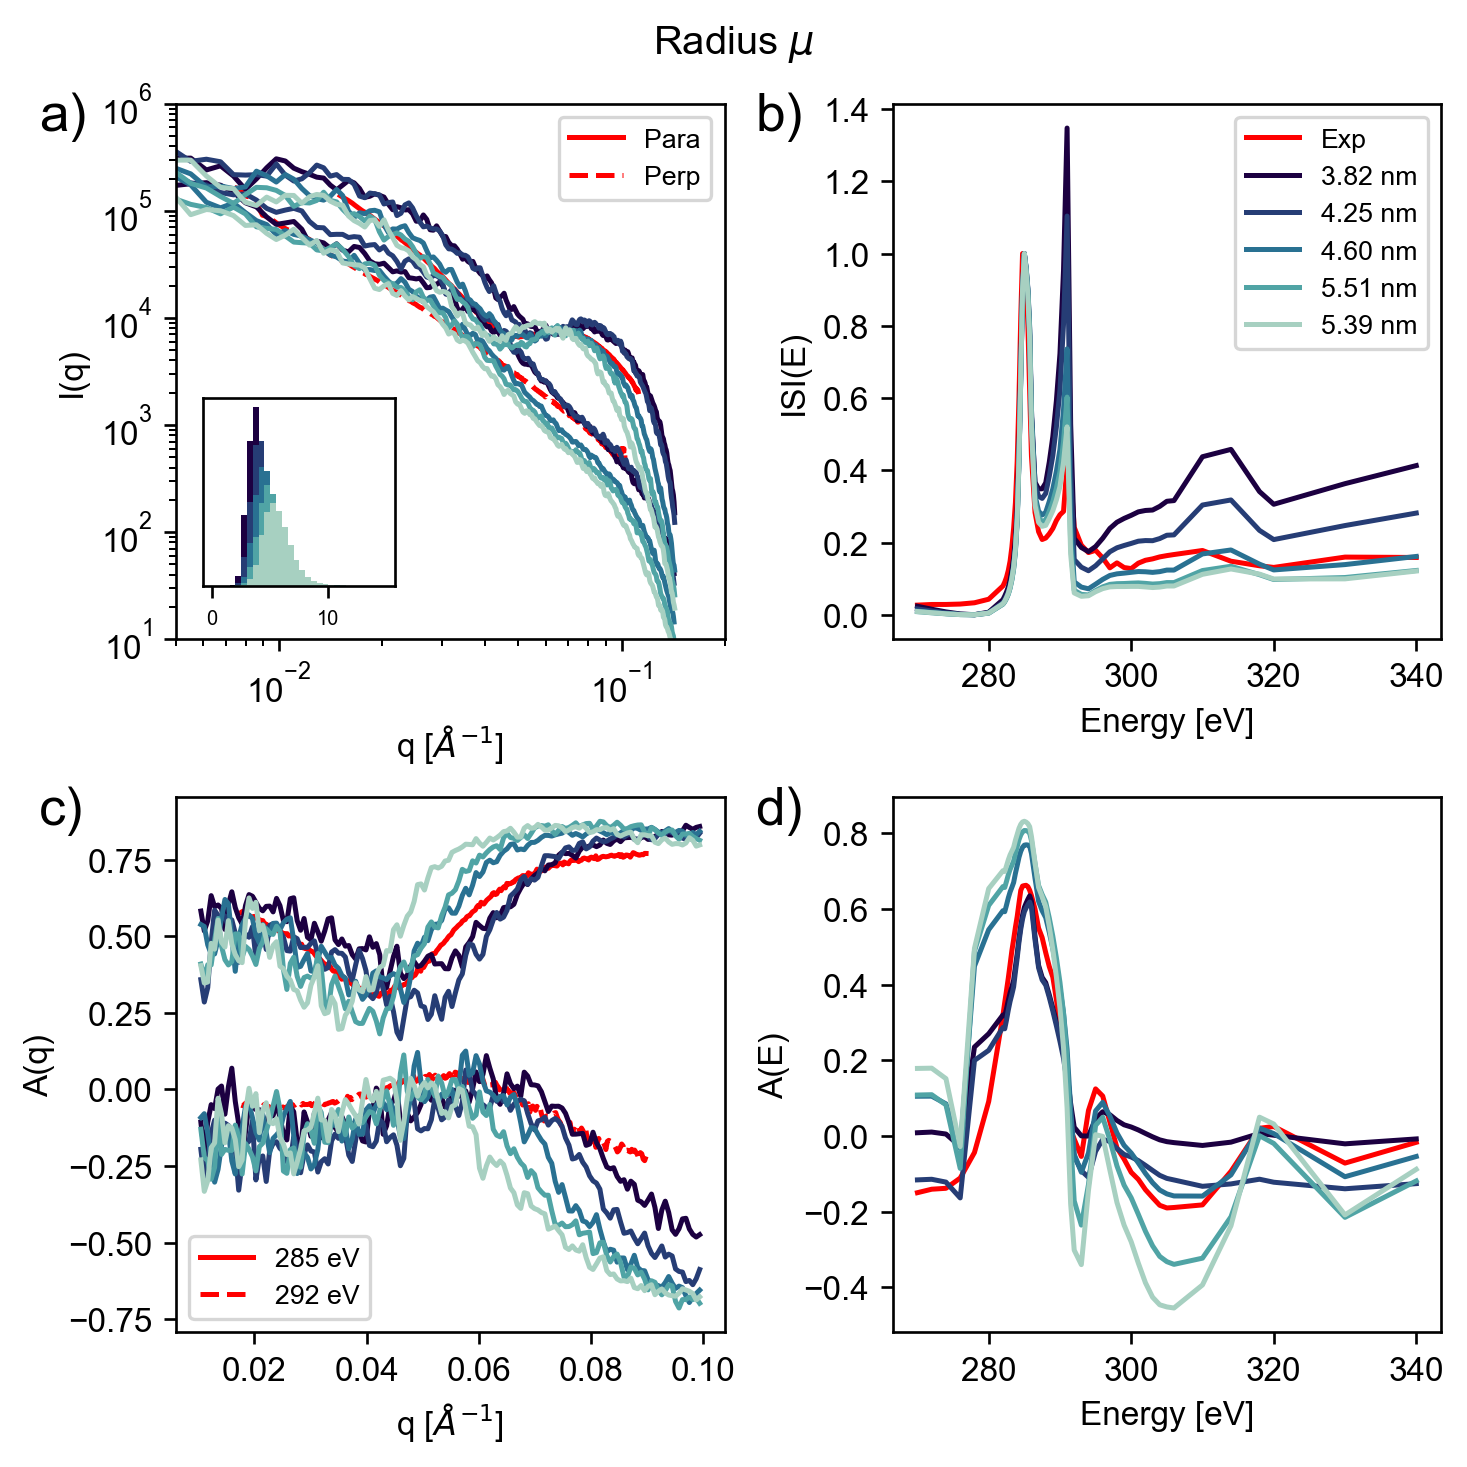

In [7]:
count = 0
fig, ax = plt.subplots(2,2,figsize=(6,6),dpi=240,constrained_layout=True)
ax = ax.flatten()
radii_means = []
## inset
ax_ins = ax[0].inset_axes([0.05, 0.1, 0.35, 0.35])
colors = cmr.ocean(np.linspace(0,1,6))
for i in r_vary:
    da1 = xr.load_dataarray(f'Data/parameter_sweep/paramsweep_{i}.nc')
    _ = save_plot_multiple(da1, da1.radius_mu, da1.radius_sigma, da1.hollow_fraction, count, colors[count])
    _ = ax_ins.hist(da1.attrs['cnt_radii'], bins=30, color=colors[count],range=(0,15))
    radii_means.append(stats.lognorm.fit(da1.attrs['cnt_radii'])[-1])
    count +=1



ax[0].set_ylim(1e1,1e6)
ax[0].set_xlim(5e-3, 0.2)
{axes.set_title('') for axes in ax}
ax[0].set_xlabel(r'q [$\AA^{-1}$]')
ax[2].set_xlabel(r'q [$\AA^{-1}$]')

ax[0].legend(['Para', 'Perp'], fontsize=8)
ax[2].legend(['285 eV', '292 eV'], fontsize=8, loc='lower left')


ax[1].set_xlabel('Energy [eV]')
ax[3].set_xlabel('Energy [eV]')
ax[0].set_ylabel('I(q)')
ax[1].set_ylabel('ISI(E)')
ax[2].set_ylabel('A(q)')
ax[3].set_ylabel('A(E)')

ax[0].text(-0.25, 0.95, 'a)', transform=ax[0].transAxes, fontsize=16)
ax[1].text(-0.25, 0.95, 'b)', transform=ax[1].transAxes, fontsize=16)
ax[2].text(-0.25, 0.95, 'c)', transform=ax[2].transAxes, fontsize=16)
ax[3].text(-0.25, 0.95, 'd)', transform=ax[3].transAxes, fontsize=16)

ax[1].legend(['Exp', *[str(h)[:4] + ' nm' for h in radii_means]],fontsize=8)
plt.suptitle(r'Radius $\mu$')
ax_ins.tick_params(axis='both', left=False, labelleft=False, labelsize=6)
plt.savefig('Figures/radius_mu_sweep.pdf', format='pdf', bbox_inches='tight')
plt.show()

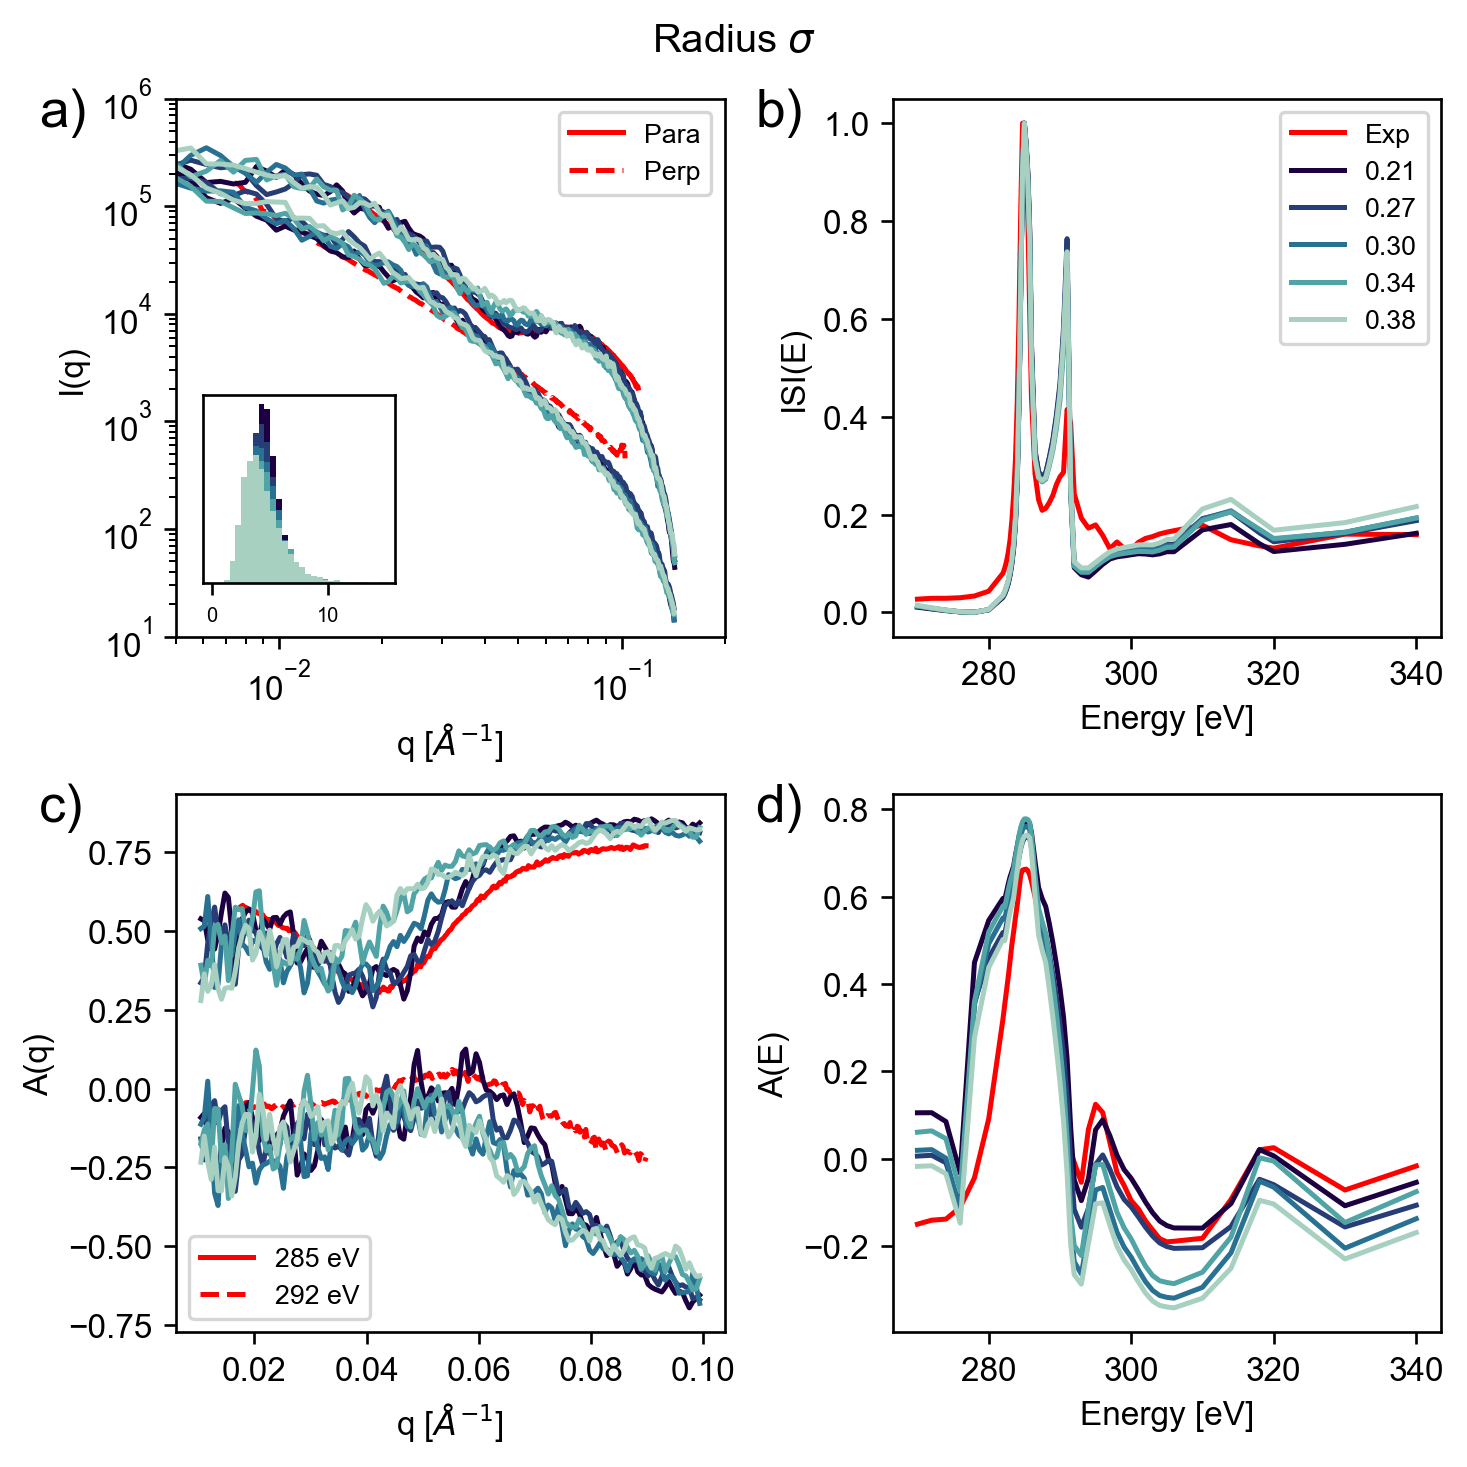

In [8]:
count = 0
fig, ax = plt.subplots(2,2,figsize=(6,6),dpi=240,constrained_layout=True)
ax = ax.flatten()
## inset
ax_ins = ax[0].inset_axes([0.05, 0.1, 0.35, 0.35])
colors = cmr.ocean(np.linspace(0,1,6))
radii_stds = []
for i in sigma_vary:
    da1 = xr.load_dataarray(f'Data/parameter_sweep/paramsweep_{i}.nc')
    _ = save_plot_multiple(da1, da1.radius_mu, da1.radius_sigma, da1.hollow_fraction, count, colors[count])
    _ = ax_ins.hist(da1.attrs['cnt_radii'], bins=30, color=colors[count], range=(0,15))
    radii_stds.append(stats.lognorm.fit(da1.attrs['cnt_radii'])[0])
    count +=1



ax[0].set_ylim(1e1,1e6)
ax[0].set_xlim(5e-3, 0.2)
{axes.set_title('') for axes in ax}
ax[0].set_xlabel(r'q [$\AA^{-1}$]')
ax[2].set_xlabel(r'q [$\AA^{-1}$]')

ax[0].legend(['Para', 'Perp'], fontsize=8)
ax[2].legend(['285 eV', '292 eV'], fontsize=8, loc='lower left')

ax[1].set_xlabel('Energy [eV]')
ax[3].set_xlabel('Energy [eV]')
ax[0].set_ylabel('I(q)')
ax[1].set_ylabel('ISI(E)')
ax[2].set_ylabel('A(q)')
ax[3].set_ylabel('A(E)')

ax[0].text(-0.25, 0.95, 'a)', transform=ax[0].transAxes, fontsize=16)
ax[1].text(-0.25, 0.95, 'b)', transform=ax[1].transAxes, fontsize=16)
ax[2].text(-0.25, 0.95, 'c)', transform=ax[2].transAxes, fontsize=16)
ax[3].text(-0.25, 0.95, 'd)', transform=ax[3].transAxes, fontsize=16)

ax[1].legend(['Exp', *[str(h)[:4] for h in radii_stds]],fontsize=8)
plt.suptitle(r'Radius $\sigma$')
ax_ins.tick_params(axis='both', left=False, labelleft=False, labelsize=6)
plt.savefig('Figures/radius_sigma_sweep.pdf', format='pdf', bbox_inches='tight')
plt.show()

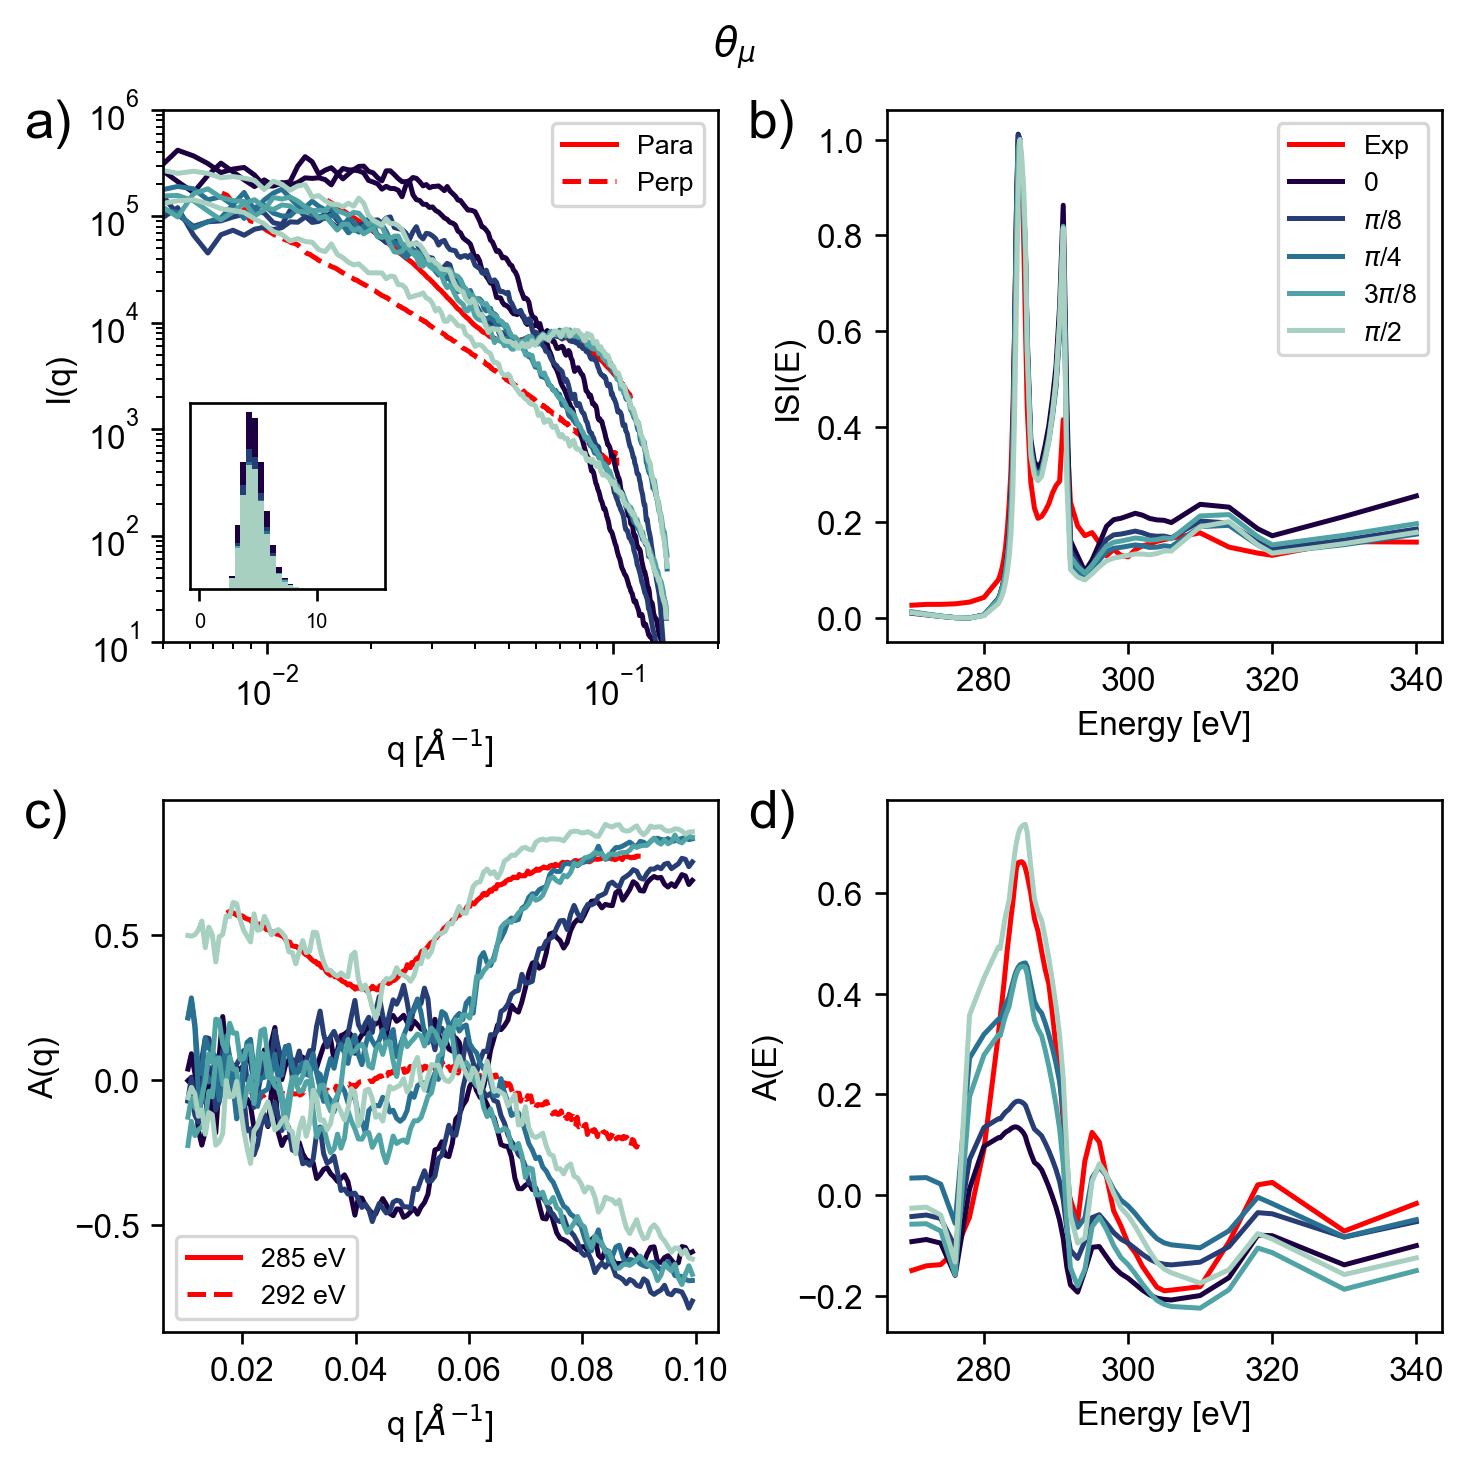

In [9]:
count = 0
fig, ax = plt.subplots(2,2,figsize=(6,6),dpi=240,constrained_layout=True)
ax = ax.flatten()
## inset
ax_ins = ax[0].inset_axes([0.05, 0.1, 0.35, 0.35])
colors = cmr.ocean(np.linspace(0,1,6))
for i in range(5):
    da1 = xr.load_dataarray(f'Data/theta_mu/mu_{i}.nc')
    _ = save_plot_multiple(da1, da1.radius_mu, da1.radius_sigma, da1.hollow_fraction, count, colors[count])
    _ = ax_ins.hist(da1.attrs['cnt_radii'], bins=30, color=colors[count], range=(0,15))
    count +=1



ax[0].set_ylim(1e1,1e6)
ax[0].set_xlim(5e-3, 0.2)
{axes.set_title('') for axes in ax}
ax[0].set_xlabel(r'q [$\AA^{-1}$]')
ax[2].set_xlabel(r'q [$\AA^{-1}$]')

ax[0].legend(['Para', 'Perp'], fontsize=8)
ax[2].legend(['285 eV', '292 eV'], fontsize=8, loc='lower left')


ax[1].set_xlabel('Energy [eV]')
ax[3].set_xlabel('Energy [eV]')
ax[0].set_ylabel('I(q)')
ax[1].set_ylabel('ISI(E)')
ax[2].set_ylabel('A(q)')
ax[3].set_ylabel('A(E)')

ax[0].text(-0.25, 0.95, 'a)', transform=ax[0].transAxes, fontsize=16)
ax[1].text(-0.25, 0.95, 'b)', transform=ax[1].transAxes, fontsize=16)
ax[2].text(-0.25, 0.95, 'c)', transform=ax[2].transAxes, fontsize=16)
ax[3].text(-0.25, 0.95, 'd)', transform=ax[3].transAxes, fontsize=16)


ax[1].legend(['Exp', '0', r'$\pi$/8', r'$\pi$/4', r'3$\pi$/8', r'$\pi$/2'], fontsize=8)
plt.suptitle(r'$\theta_\mu$')
ax_ins.tick_params(axis='both', left=False, labelleft=False, labelsize=6)
plt.savefig('Figures/theta_mu_sweep.pdf', format='pdf', bbox_inches='tight')
plt.show()

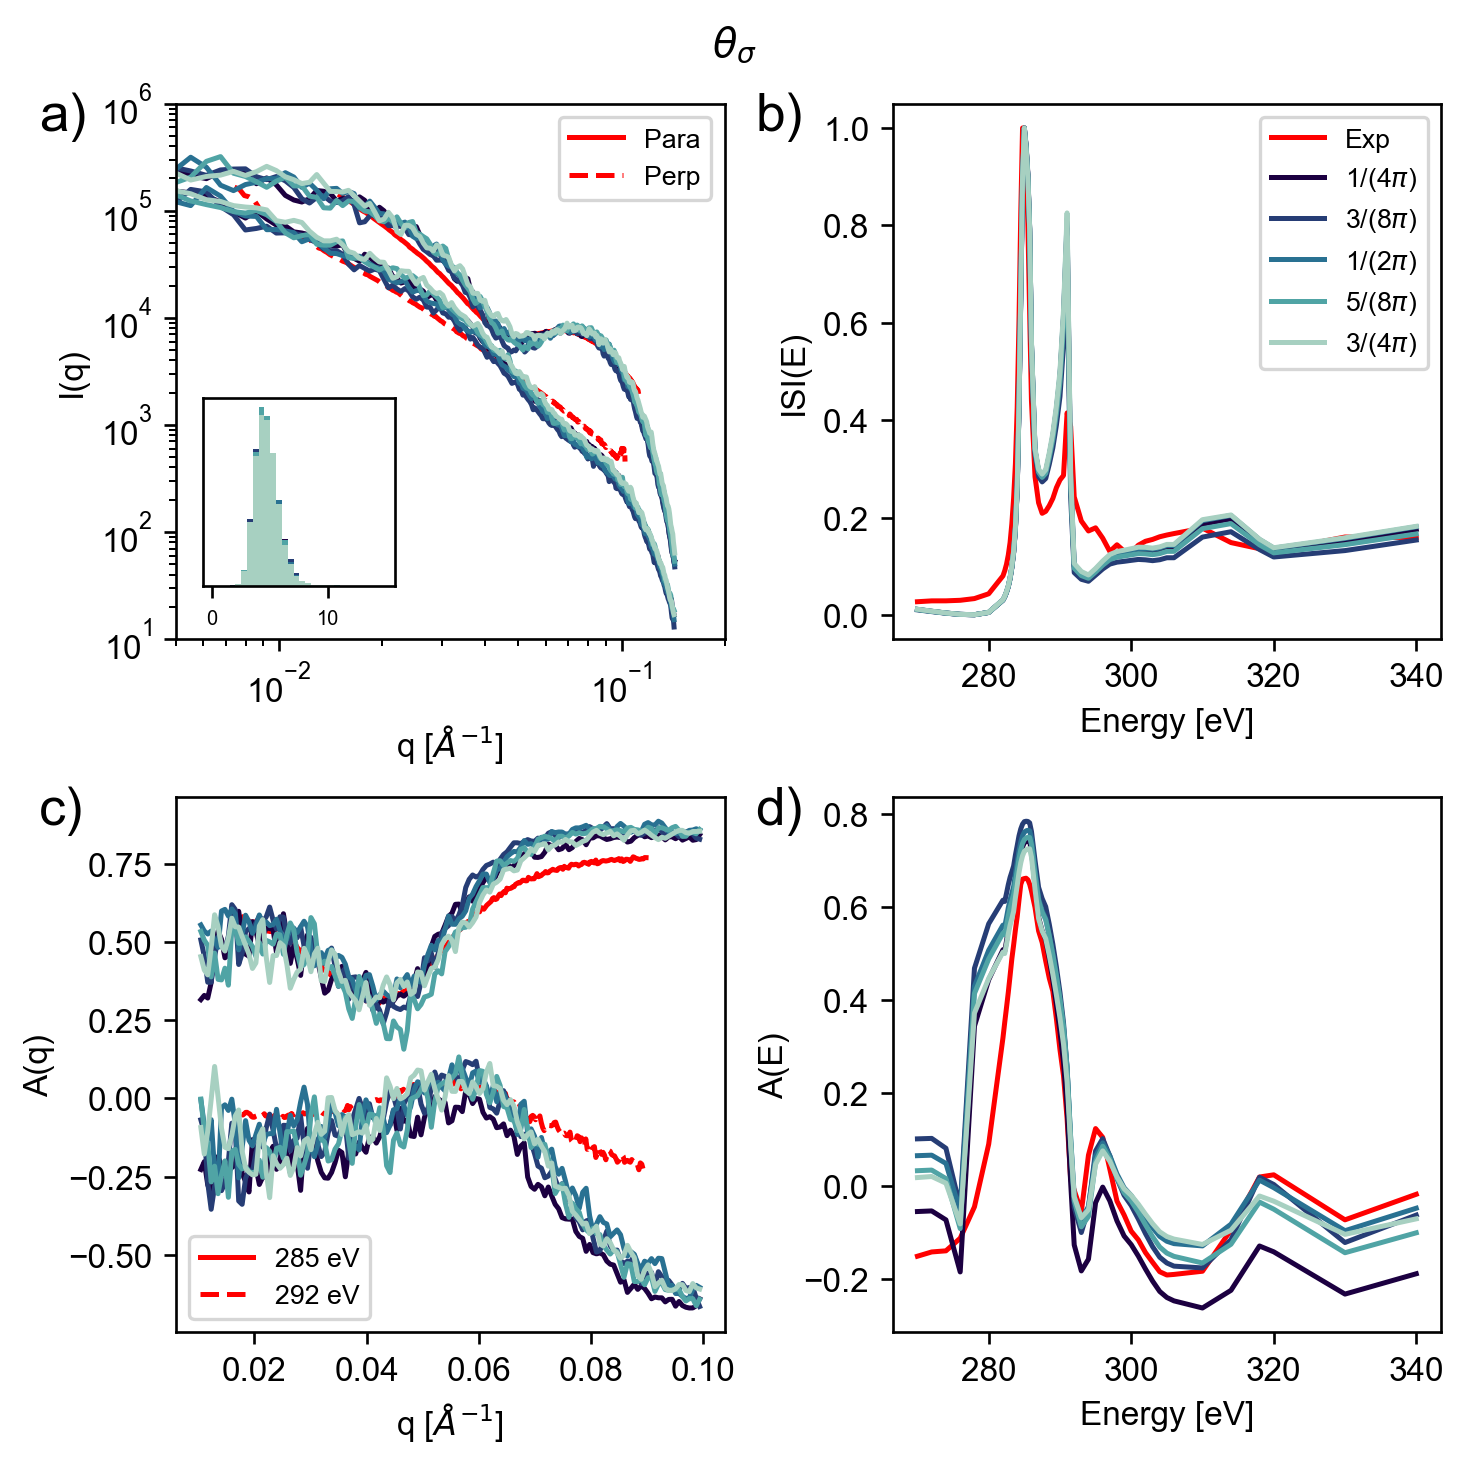

In [10]:
count = 0
fig, ax = plt.subplots(2,2,figsize=(6,6),dpi=240,constrained_layout=True)
ax = ax.flatten()
## inset
ax_ins = ax[0].inset_axes([0.05, 0.1, 0.35, 0.35])
colors = cmr.ocean(np.linspace(0,1,6))
for i in range(5):
    da1 = xr.load_dataarray(f'Data/theta_sigma/sigma_{i}.nc')
    _ = save_plot_multiple(da1, da1.radius_mu, da1.radius_sigma, da1.hollow_fraction, count, colors[count])
    _ = ax_ins.hist(da1.attrs['cnt_radii'], bins=30, color=colors[count], range=(0,15))
    count +=1



ax[0].set_ylim(1e1,1e6)
ax[0].set_xlim(5e-3, 0.2)
ax[0].legend(['Para', 'Perp'], fontsize=8)
ax[2].legend(['285 eV', '292 eV'], fontsize=8, loc='lower left')
{axes.set_title('') for axes in ax}
ax[0].set_xlabel(r'q [$\AA^{-1}$]')
ax[2].set_xlabel(r'q [$\AA^{-1}$]')

ax[1].set_xlabel('Energy [eV]')
ax[3].set_xlabel('Energy [eV]')
ax[0].set_ylabel('I(q)')
ax[1].set_ylabel('ISI(E)')
ax[2].set_ylabel('A(q)')
ax[3].set_ylabel('A(E)')

ax[0].text(-0.25, 0.95, 'a)', transform=ax[0].transAxes, fontsize=16)
ax[1].text(-0.25, 0.95, 'b)', transform=ax[1].transAxes, fontsize=16)
ax[2].text(-0.25, 0.95, 'c)', transform=ax[2].transAxes, fontsize=16)
ax[3].text(-0.25, 0.95, 'd)', transform=ax[3].transAxes, fontsize=16)


ax[1].legend(['Exp', r'1/(4$\pi$)', r'3/(8$\pi$)', r'1/(2$\pi$)', r'5/(8$\pi$)', r'3/(4$\pi$)', r'1/$\pi$'], fontsize=8)
plt.suptitle(r'$\theta_\sigma$')
ax_ins.tick_params(axis='both', left=False, labelleft=False, labelsize=6)
plt.savefig('Figures/theta_sigma_sweep.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### Radial vs. Co-aligned

In [11]:
def save_plot_multiple(simulation_chi, radius_value, radius_sigma_value, hollow_value, count,color):
    if count == 0:
        (exp_ax0).sel(q=slice(1.5e-2,.15)).plot(yscale='log',xscale='log', ax=ax[0],color='r',label='Exp')
        exp_ax0_1.plot(ax=ax[0], color='r', linestyle='--')
        exp_ax1.plot(ax=ax[1], color='r')
        exp_ax2.plot(ax=ax[2], color='r')
        exp_ax2_1.plot(ax=ax[2], color='r', linestyle='--')
        exp_ax3.plot(ax=ax[3], color='r')

    
    horz = simulation_chi.sel(chi=slice(-20,20)).mean('chi')
    vert = simulation_chi.sel(chi=slice(-110,-70)).mean('chi')
    A = (horz - vert) / (horz + vert)
    isi_sim = simulation_chi.sel(q=slice(0.06,0.07)).mean(['q','chi'])
    
    ### simulation plotting
    (horz.sel(energy=285)/horz.sel(energy=285, q=slice(0.06,0.07)).mean('q')*norm_val).plot(ax=ax[0], label=hollow_fraction,color=color)
    (vert.sel(energy=285)/horz.sel(energy=285, q=slice(0.06,0.07)).mean('q')*norm_val).plot(ax=ax[0], label=hollow_fraction,color=color, linestyle='--')    
    (isi_sim/isi_sim.sel(energy=285)).plot(ax=ax[1],color=color)
    A.sel(energy=285,q=slice(1e-2,.1)).plot(ax=ax[2],color=color)
    A.sel(energy=292, q=slice(1e-2, 0.1)).plot(ax=ax[2],color=color, linestyle='--')
    A.sel(q=slice(0.06, 0.07)).mean('q').plot(ax=ax[3],color=color)

In [12]:
da1 = xr.load_dataarray('Data/theta_psi_radial.nc')

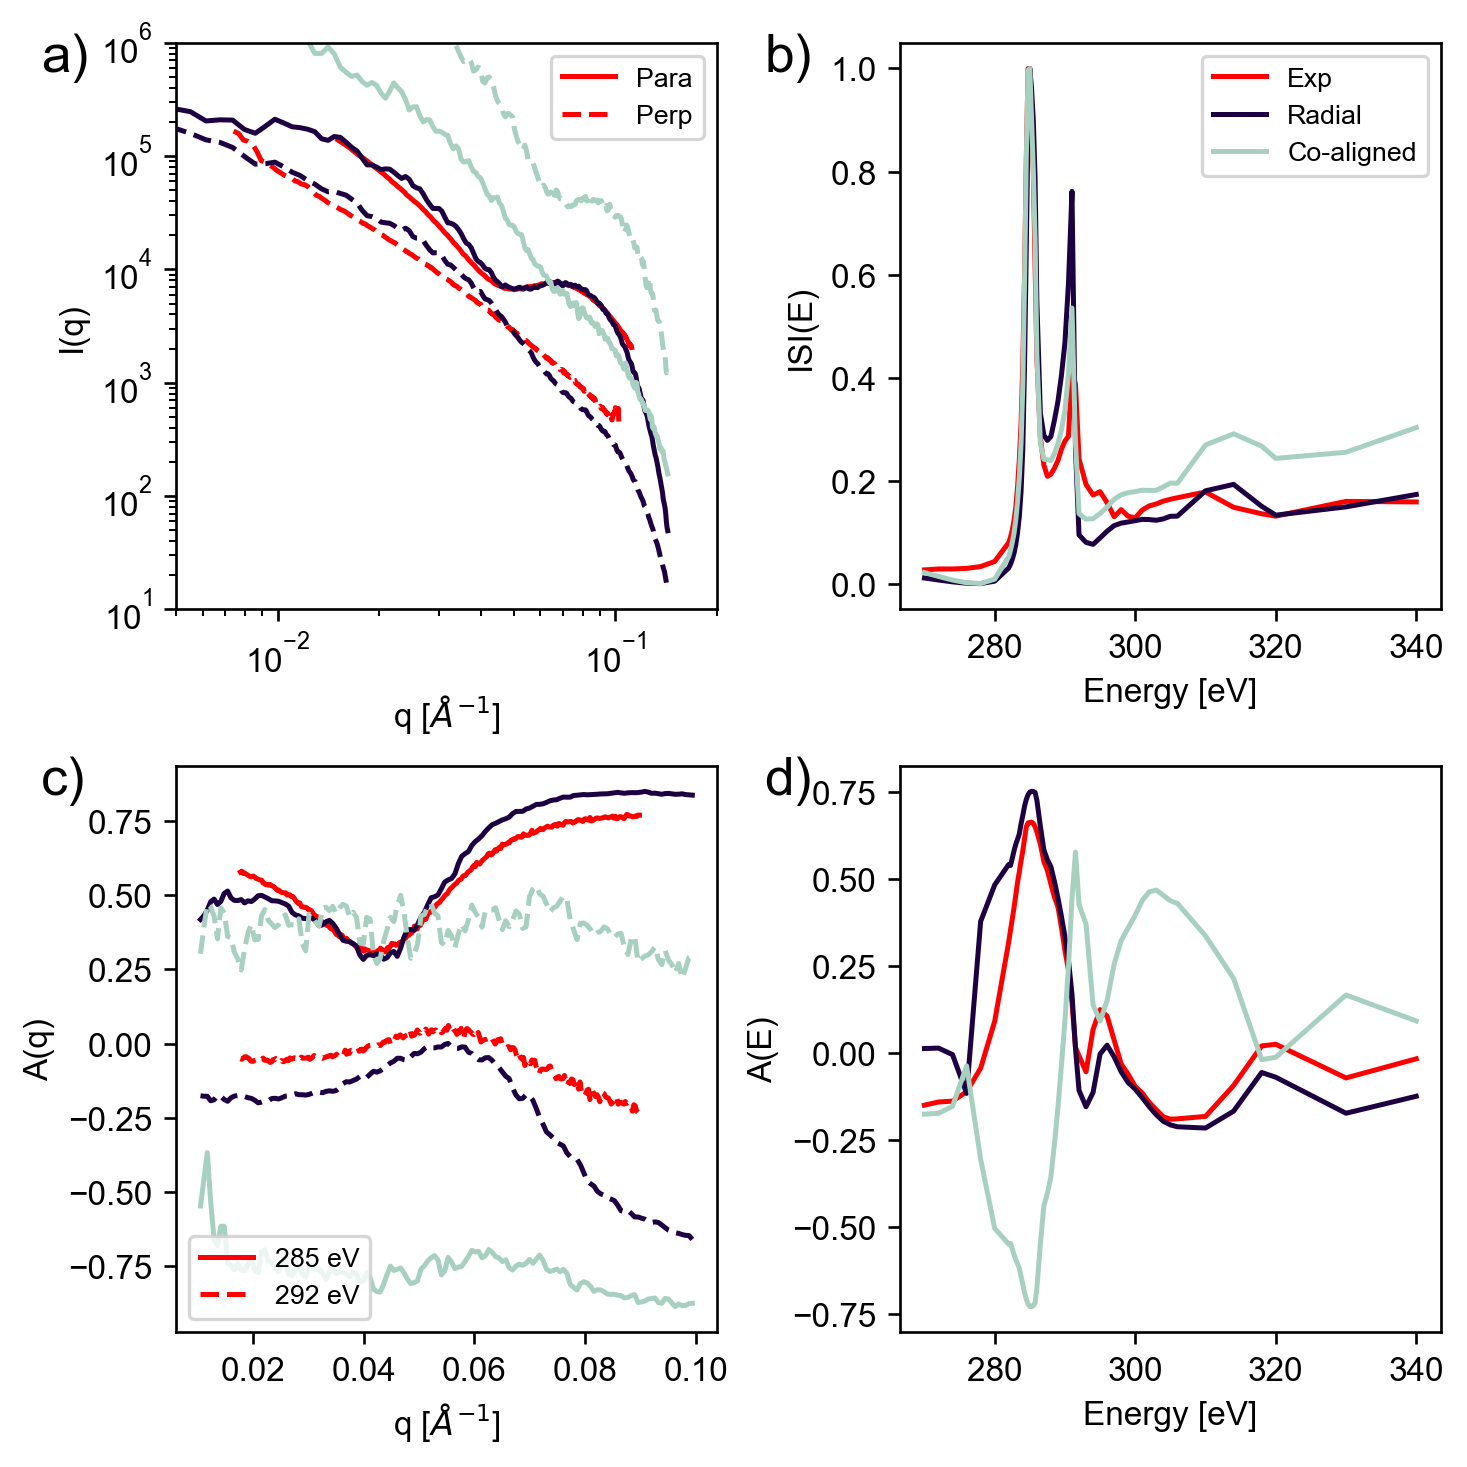

In [13]:
count = 0
fig, ax = plt.subplots(2,2,figsize=(6,6),dpi=240,constrained_layout=True)
ax = ax.flatten()
## inset
colors = cmr.ocean(np.linspace(0,1,6))

da1 = xr.load_dataarray('Data/theta_psi_radial.nc')
_ = save_plot_multiple(da1, da1.radius_mu, da1.radius_sigma, da1.hollow_fraction, count, colors[0])
count += 1
da1 = xr.load_dataarray('Data/theta_psi_coaligned.nc')
_ = save_plot_multiple(da1, da1.radius_mu, da1.radius_sigma, da1.hollow_fraction, count, colors[-2])



ax[0].set_ylim(1e1,1e6)
ax[0].set_xlim(5e-3, 0.2)
{axes.set_title('') for axes in ax}
ax[0].set_xlabel(r'q [$\AA^{-1}$]')
ax[2].set_xlabel(r'q [$\AA^{-1}$]')

ax[0].legend(['Para', 'Perp'], fontsize=8)
ax[2].legend(['285 eV', '292 eV'], fontsize=8, loc='lower left')

ax[1].set_xlabel('Energy [eV]')
ax[3].set_xlabel('Energy [eV]')
ax[0].set_ylabel('I(q)')
ax[1].set_ylabel('ISI(E)')
ax[2].set_ylabel('A(q)')
ax[3].set_ylabel('A(E)')

ax[0].text(-0.25, 0.95, 'a)', transform=ax[0].transAxes, fontsize=16)
ax[1].text(-0.25, 0.95, 'b)', transform=ax[1].transAxes, fontsize=16)
ax[2].text(-0.25, 0.95, 'c)', transform=ax[2].transAxes, fontsize=16)
ax[3].text(-0.25, 0.95, 'd)', transform=ax[3].transAxes, fontsize=16)


ax[1].legend(['Exp', 'Radial', 'Co-aligned'],fontsize=8)
# plt.suptitle(r'Radius $\sigma$')
ax_ins.tick_params(axis='both', left=False, labelleft=False, labelsize=6)
plt.savefig('Figures/orientation_test.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Optimized Model

In [14]:
cnt0 = xr.load_dataarray('Data/RSoXS/CNT_pol0_WAXS.nc')
cnt0_saxs = xr.load_dataarray('Data/RSoXS/CNT_pol0_SAXS.nc')
horz_exp = cnt0.sel(chi=slice(-20,20)).mean('chi')
vert_exp = cnt0.sel(chi=slice(-110,-70)).mean('chi')
A_exp = (horz_exp - vert_exp) / (horz_exp + vert_exp)
horz_saxs = cnt0_saxs.sel(chi=slice(-20,20)).mean('chi')
vert_saxs = cnt0_saxs.sel(chi=slice(-110,-70)).mean('chi')
A_saxs = (horz_saxs - vert_saxs) / (horz_saxs + vert_saxs)

In [15]:
da1 = xr.load_dataarray('Data/theta_psi_radial.nc')

In [16]:
horz = da1.sel(chi=slice(-20,20),q=slice(1.5e-3,1.2e-1)).mean('chi')
vert = da1.sel(chi=slice(-110,-70),q=slice(1.5e-3,1.2e-1)).mean('chi')
A = (horz - vert) / (horz + vert)
isi_sim = da1.sel(q=slice(0.06,0.07)).mean(['q','chi'])

In [17]:
### lower left plot
exp_ax2 = A_exp.sel(energy=285).sel(q=slice(0.0175, 0.1))
exp_ax2_1 = A_exp.sel(energy=292).sel(q=slice(0.0175, 0.1))

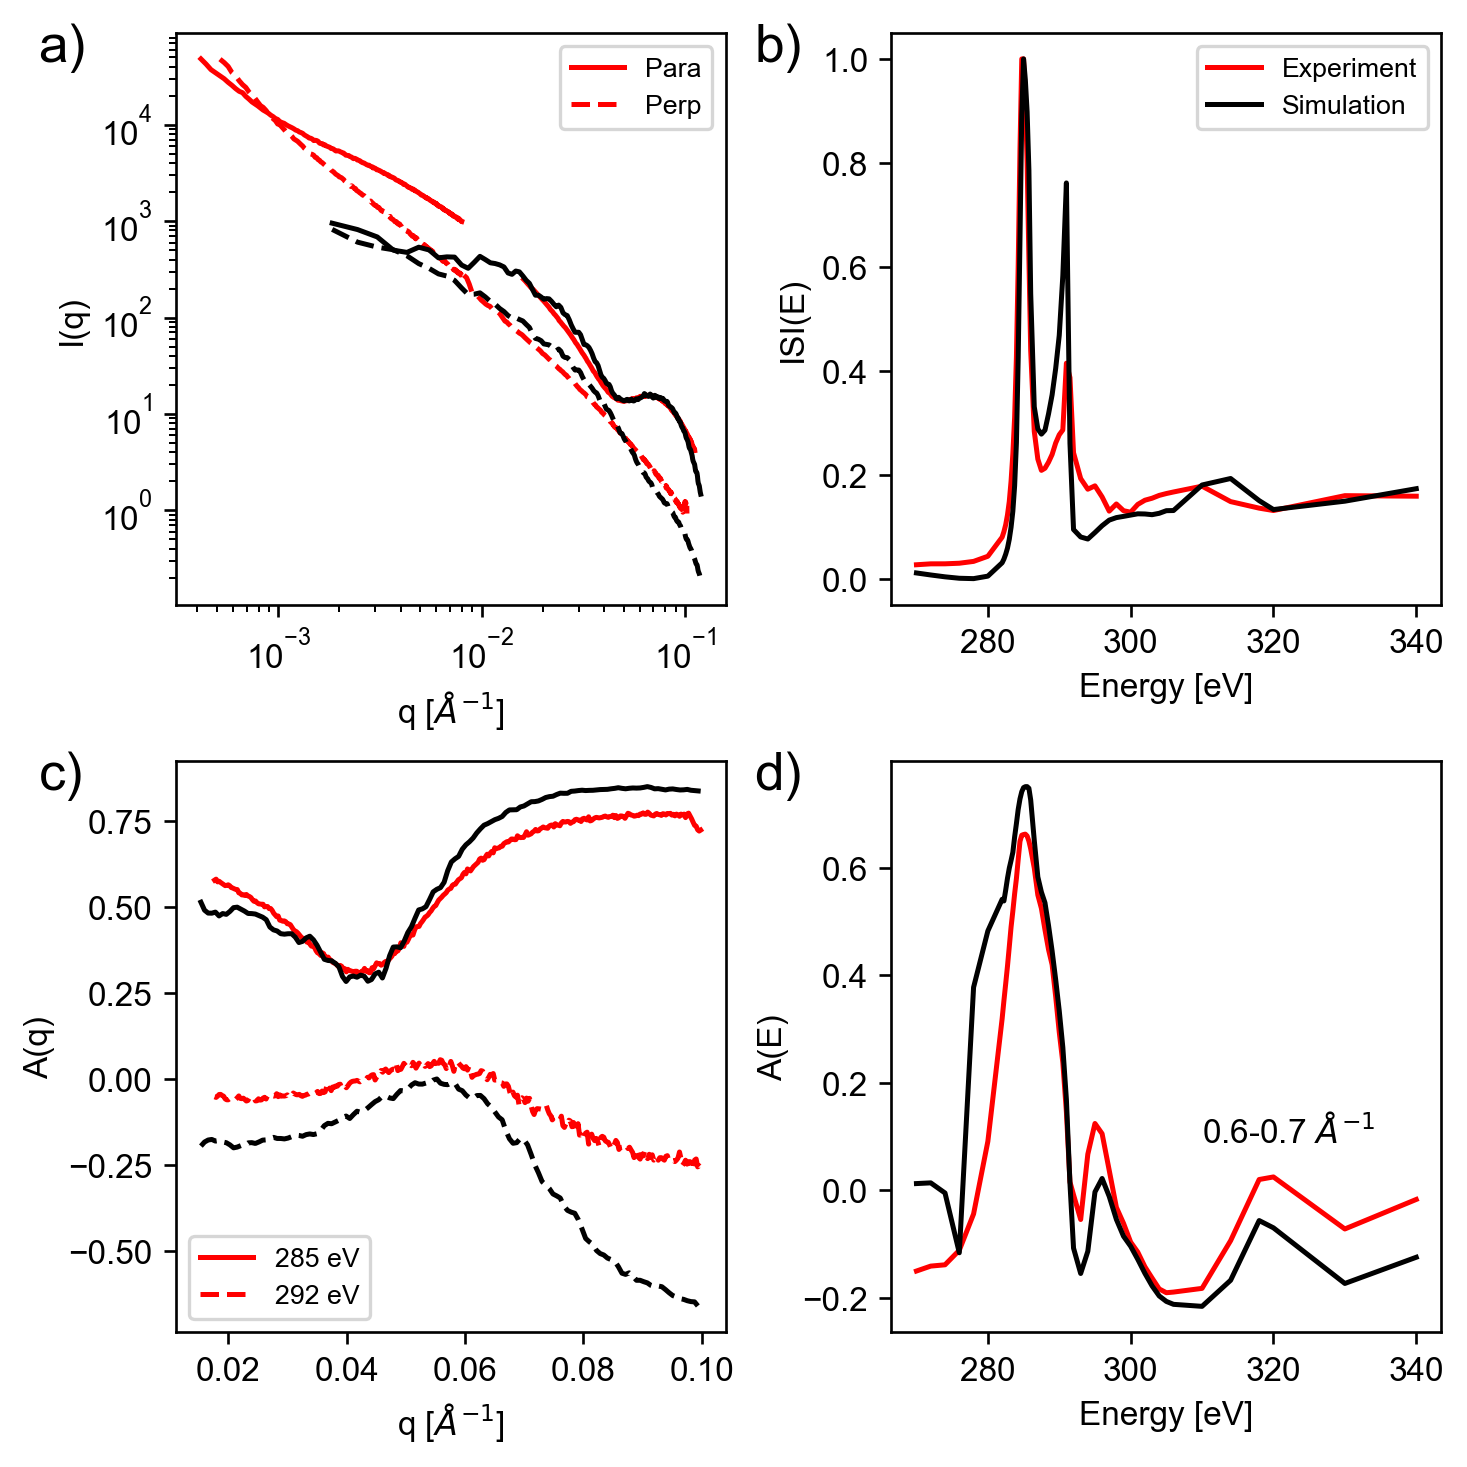

In [21]:
fig, ax = plt.subplots(2,2,figsize=(6,6),dpi=240,constrained_layout=True)
ax = ax.flatten()

horz_saxs.sel(energy=285,q=slice(4e-4,8e-3)).plot(yscale='log',xscale='log', color='r',ax=ax[0])
vert_saxs.sel(energy=285,q=slice(4e-4,8e-3)).plot(color='r',linestyle='--',ax=ax[0])

(horz_exp.sel(energy=285,q=slice(1.6e-2,1.5e-1))/4.9e2).plot(color='r',ax=ax[0])
(vert_exp.sel(energy=285,q=slice(8e-3,1.5e-1))/4.9e2).plot(color='r',linestyle='--',ax=ax[0])

(horz.sel(energy=285)/horz.sel(energy=285, q=slice(0.06,0.07)).mean('q')*norm_val/4.9e2).plot(ax=ax[0],color='k')
(vert.sel(energy=285)/horz.sel(energy=285, q=slice(0.06,0.07)).mean('q')*norm_val/4.9e2).plot(ax=ax[0],color='k', linestyle='--')


exp_ax1.plot(ax=ax[1], color='r')
exp_ax2.plot(ax=ax[2], color='r')
exp_ax2_1.plot(ax=ax[2], color='r', linestyle='--')
exp_ax3.plot(ax=ax[3], color='r')



(isi_sim/isi_sim.sel(energy=285)).plot(ax=ax[1],color='k')
A.sel(energy=285,q=slice(1.5e-2,.1)).plot(ax=ax[2],color='k')
A.sel(energy=292, q=slice(1.5e-2, 0.1)).plot(ax=ax[2],color='k', linestyle='--')
A.sel(q=slice(0.06, 0.07)).mean('q').plot(ax=ax[3],color='k')

ax[3].text(310, 0.09, r'0.6-0.7 $\AA^{-1}$')

ax[0].set_title('')
ax[2].set_title('')
ax[0].set_xlabel(r'q [$\AA^{-1}$]')
ax[2].set_xlabel(r'q [$\AA^{-1}$]')

ax[0].legend(['Para', 'Perp'], fontsize=8)
ax[1].legend(['Experiment','Simulation'],fontsize=8)
ax[2].legend(['285 eV', '292 eV'], fontsize=8, loc='lower left')

ax[1].set_xlabel('Energy [eV]')
ax[3].set_xlabel('Energy [eV]')
ax[0].set_ylabel('I(q)')
ax[1].set_ylabel('ISI(E)')
ax[2].set_ylabel('A(q)')
ax[3].set_ylabel('A(E)')

ax[0].text(-0.25, 0.95, 'a)', transform=ax[0].transAxes, fontsize=16)
ax[1].text(-0.25, 0.95, 'b)', transform=ax[1].transAxes, fontsize=16)
ax[2].text(-0.25, 0.95, 'c)', transform=ax[2].transAxes, fontsize=16)
ax[3].text(-0.25, 0.95, 'd)', transform=ax[3].transAxes, fontsize=16)

plt.savefig('Figures/opt_model.pdf',format='pdf', bbox_inches='tight')
plt.show()

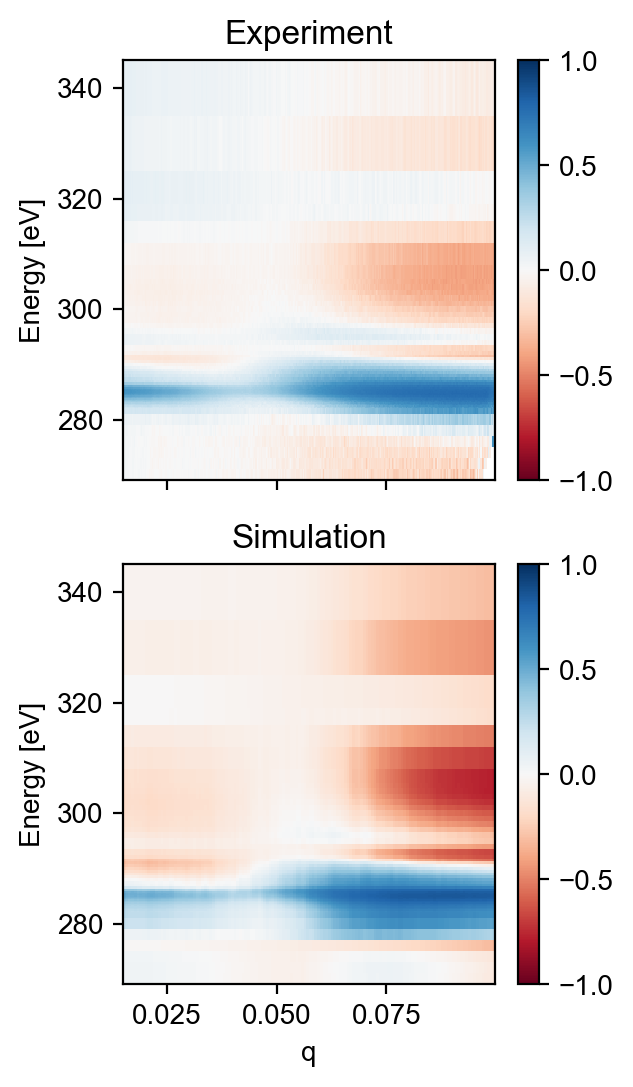

In [19]:
fig, ax = plt.subplots(2,1,figsize=(3,6),dpi=200,sharex=True)
A_exp.sel(q=slice(1.5e-2,.1)).plot(x='q',ax=ax[0],vmin=-1,vmax=1,cmap='RdBu')
A.sel(q=slice(1.5e-2,.1)).plot(x='q',ax=ax[1],vmin=-1,vmax=1,cmap='RdBu')
ax[0].set_ylabel('Energy [eV]')
ax[1].set_ylabel('Energy [eV]')
ax[0].set_xlabel('')
ax[0].set_title('Experiment')
ax[1].set_title('Simulation')
plt.savefig('Figures/A_comparison.png',format='png', dpi=300, bbox_inches='tight')